In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
app_train = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:100000, :]
app_test = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:100000, :]
bureau = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:100000, :]
bureau_balance = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:100000, :]
cash = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]
credit = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]
previous = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]
installments = pd.read_csv('C:/Users/Alireza-Lab/Desktop/home-credit-default-risk/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]

In [3]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

In [4]:
app.head()

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0      24700.5    406597.5         351000.0          202500.0   
1      35698.5   1293502.5        1129500.0          270000.0   
2       6750.0    135000.0         135000.0           67500.0   
3      29686.5    312682.5         297000.0          135000.0   
4      21865.5    513000.0         513000.0          121500.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        NaN                         NaN   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  ...  \
0                         0.0                         1.0  ...   
1                         0.0                         0.0  ...   
2                         0.0                         0.0  ...   
3                         NaN                         NaN  ...   
4                         0.0                         0.0  ...   

   TOTALAREA_MODE  WALLSMATERIAL_MODE  WEEKDAY_APPR_PROCESS_START  \
0          0.0149        Stone, brick                   WEDNESDAY   
1          0.0714               Block                      MONDAY   
2             NaN                 NaN                      MONDAY   
3             NaN                 NaN                   WEDNESDAY   
4             NaN                 NaN                    THURSDAY   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BEGINEXPLUATATION_MEDI  \
0                       0.9722                        0.9722   
1                       0.9851                        0.9851   
2                          NaN                           NaN   
3                          NaN                           NaN   
4                          NaN                           NaN   

   YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_AVG  YEARS_BUILD_MEDI  \
0                        0.9722           0.6192            0.6243   
1                        0.9851           0.7960            0.7987   
2                           NaN              NaN               NaN   
3                           NaN              NaN               NaN   
4                           NaN              NaN               NaN   

  YEARS_BUILD_MODE    set  
0           0.6341  train  
1           0.8040  train  
2              NaN  train  
3              NaN  train  
4              NaN  train  

[5 rows x 123 columns]

In [5]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

In [6]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id= 'app', dataframe= app, index='SK_ID_CURR')
es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')
es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

In [7]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [8]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 148745, Columns: 123]
    bureau [Rows: 100001, Columns: 17]
    previous [Rows: 100001, Columns: 37]
    bureau_balance [Rows: 100001, Columns: 4]
    cash [Rows: 100001, Columns: 9]
    installments [Rows: 100001, Columns: 9]
    credit [Rows: 100001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

DFS with Default Primitives

In [9]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

name         type  \
0  avg_time_between  aggregation   
1   time_since_last  aggregation   
2              skew  aggregation   
3  time_since_first  aggregation   
4            median  aggregation   
5      percent_true  aggregation   
6     n_most_common  aggregation   
7        num_unique  aggregation   
8               any  aggregation   
9              mean  aggregation   

                                                                       description  
0               Computes the average number of seconds between consecutive events.  
1        Calculates the time elapsed since the last datetime (default in seconds).  
2  Computes the extent to which a distribution differs from a normal distribution.  
3               Calculates the time elapsed since the first datetime (in seconds).  
4                            Determines the middlemost number in a list of values.  
5                                         Determines the percent of `True` values.  
6                                         Determines the `n` most common elements.  
7                 Determines the number of distinct values, ignoring `NaN` values.  
8                                     Determines if any value is 'True' in a list.  
9                                       Computes the average for a list of values.

In [10]:
primitives[primitives['type'] == 'transform'].head(10)

name       type  \
22              not_equal  transform   
23  modulo_numeric_scalar  transform   
24           greater_than  transform   
25                   diff  transform   
26                   hour  transform   
27     add_numeric_scalar  transform   
28                cum_sum  transform   
29                weekday  transform   
30                is_null  transform   
31           equal_scalar  transform   

                                                        description  
22  Determines if values in one list are not equal to another list.  
23       Return the modulo of each element in the list by a scalar.  
24  Determines if values in one list are greater than another list.  
25       Compute the difference between the value in a list and the  
26                         Determines the hour value of a datetime.  
27                          Add a scalar to each value in the list.  
28                                   Calculates the cumulative sum.  
29                  Determines the day of the week from a datetime.  
30                                   Determines if a value is null.  
31      Determines if values in a list are equal to a given scalar.

In [11]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))

2221 Total Features


In [12]:
# DFS with default primitives
#feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
#                                       trans_primitives = default_trans_primitives,
#                                       agg_primitives=default_agg_primitives, 
#                                        max_depth = 2, features_only=False, verbose = True)
#
#pd.options.display.max_columns = 1700
#feature_matrix.head(10)

In [13]:
#feature_matrix['SK_ID_CURR'] = feature_matrix.index
#feature_matrix = feature_matrix.reset_index(drop = True)

In [14]:
# Specify the aggregation primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 1215 features
Elapsed: 03:19 | Progress: 100%|██████████


In [15]:
feature_matrix['SK_ID_CURR'] = feature_matrix.index
feature_matrix = feature_matrix.reset_index(drop = True)

**Cheching whether the new variable are useful or not**

**1-Correlation**

In [16]:
corrs = feature_matrix.corr()

In [17]:
corrssort = corrs['TARGET'].fillna(0).abs().sort_values()

In [18]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

In [19]:
features_sample = feature_matrix[feature_matrix['set'] == 'train']

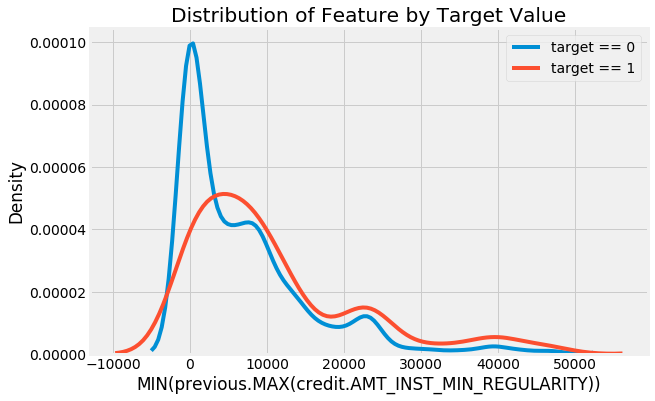

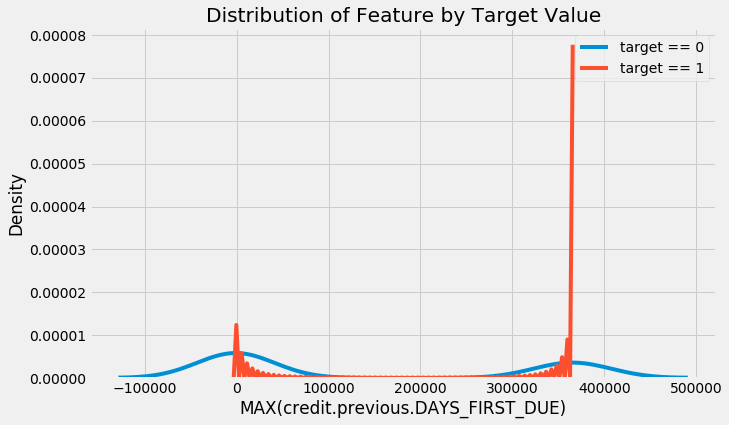

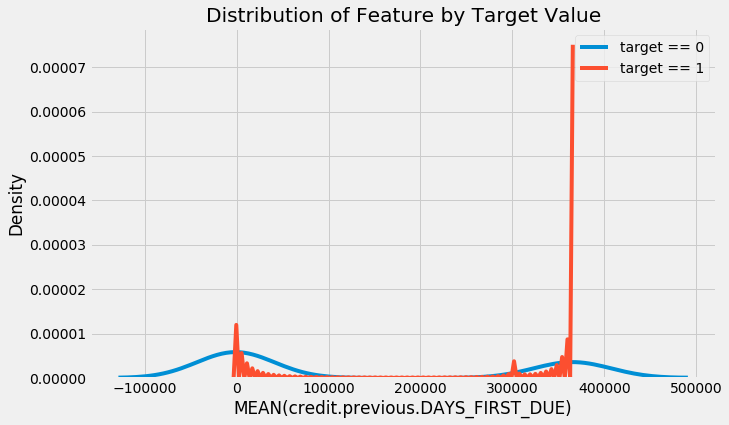

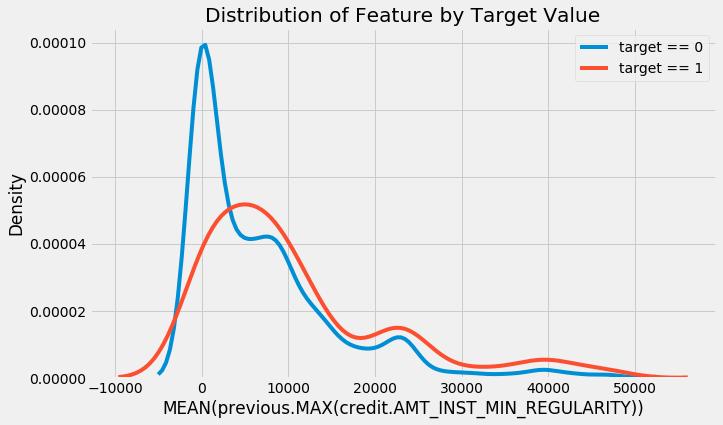

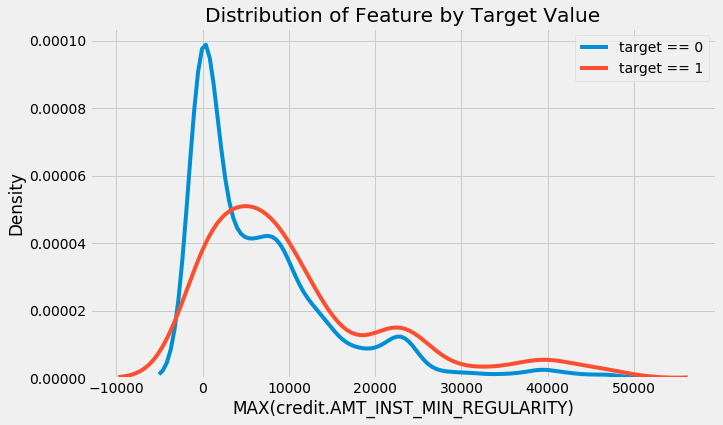

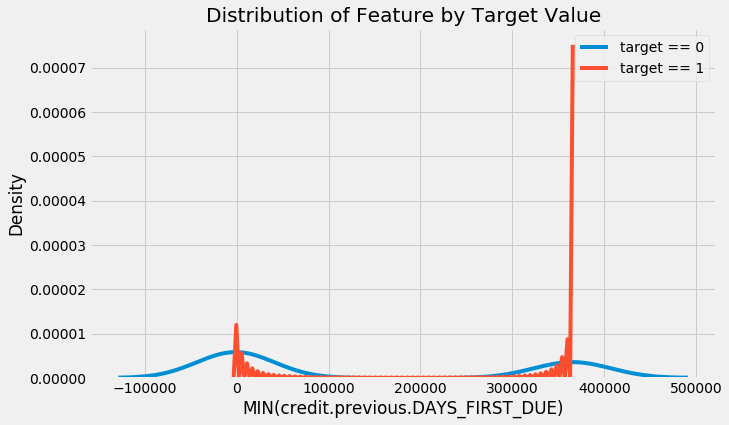

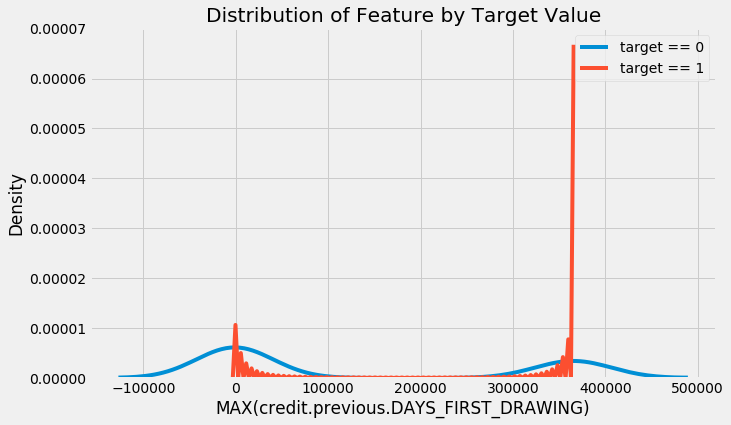

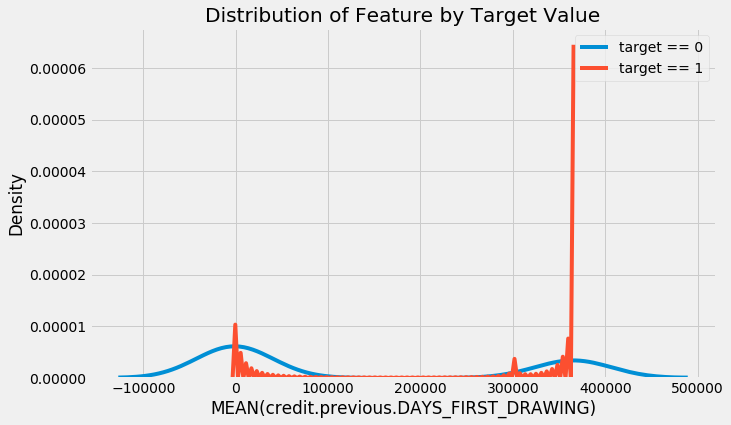

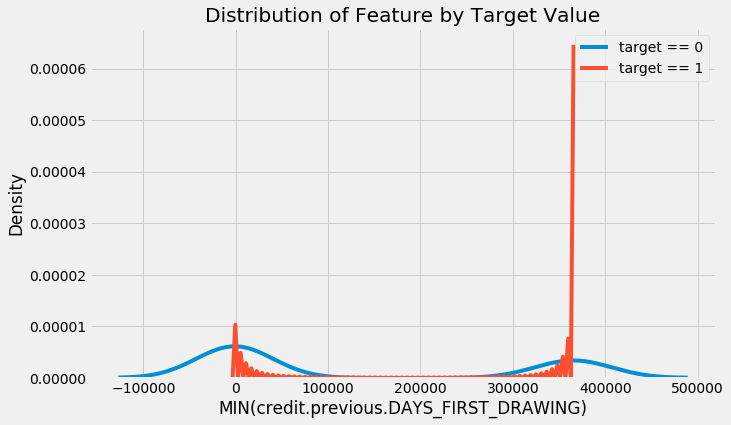

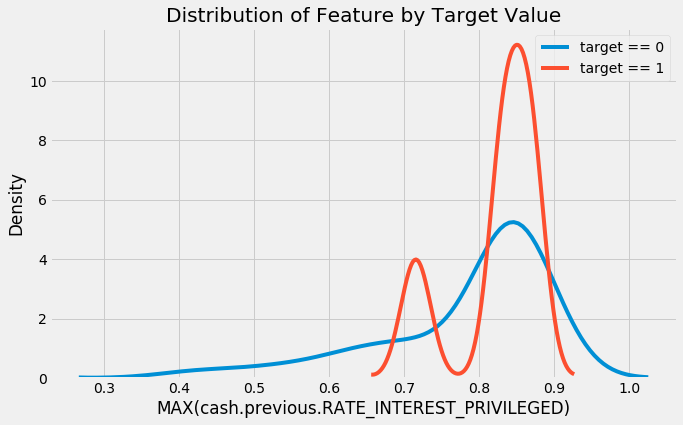

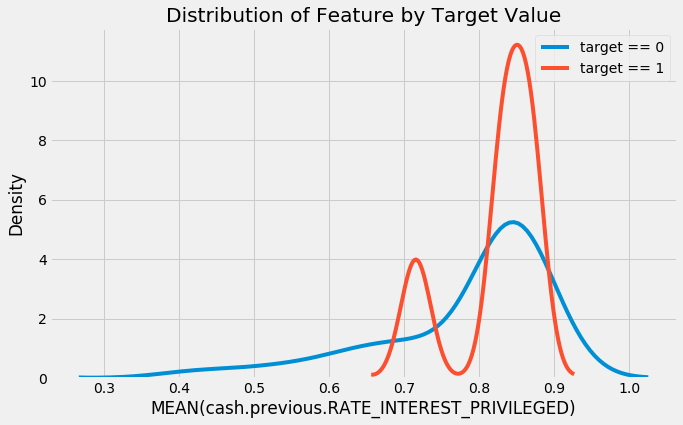

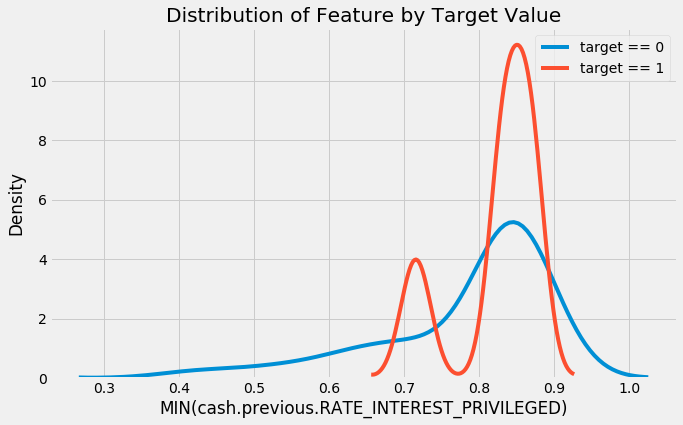

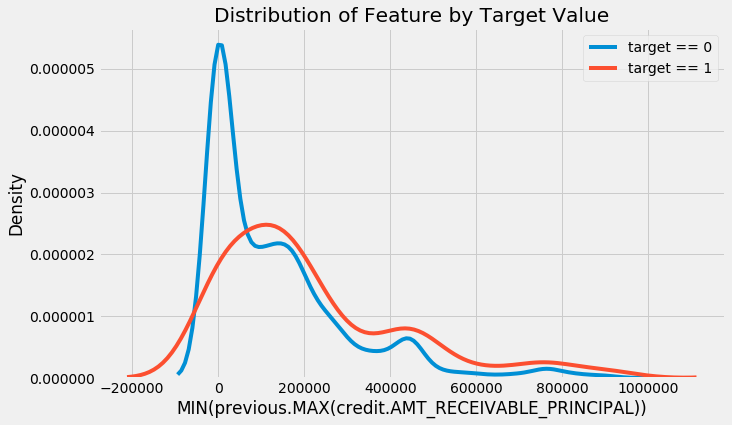

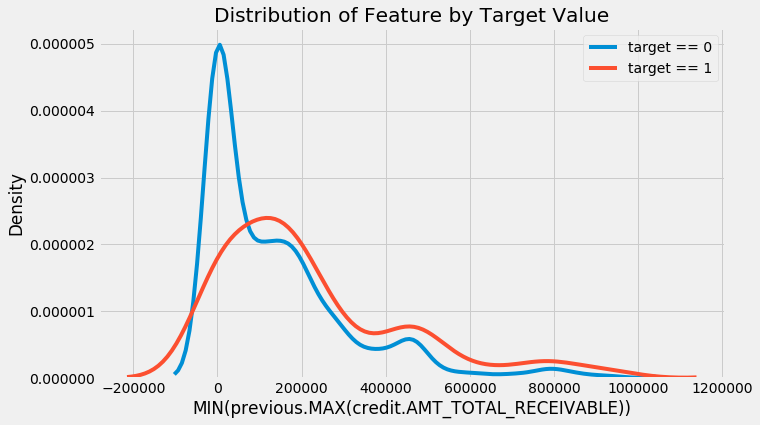

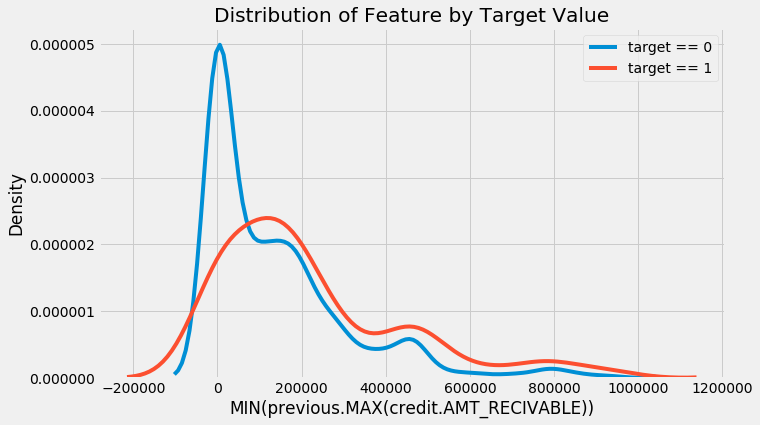

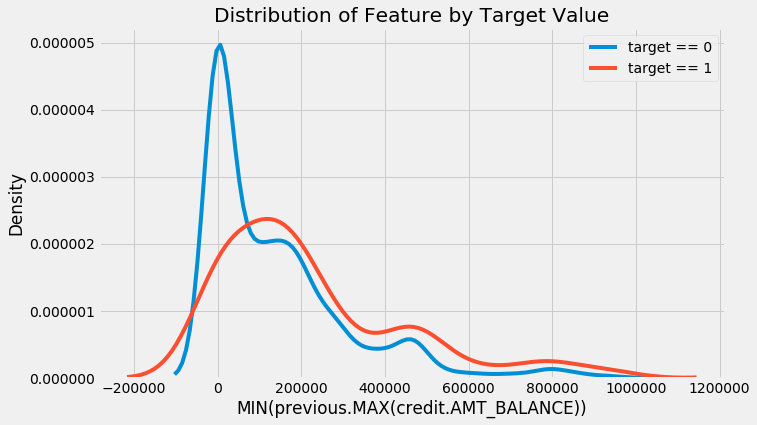

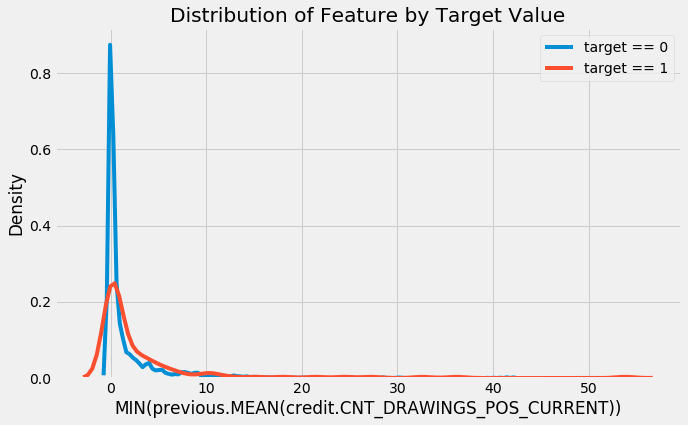

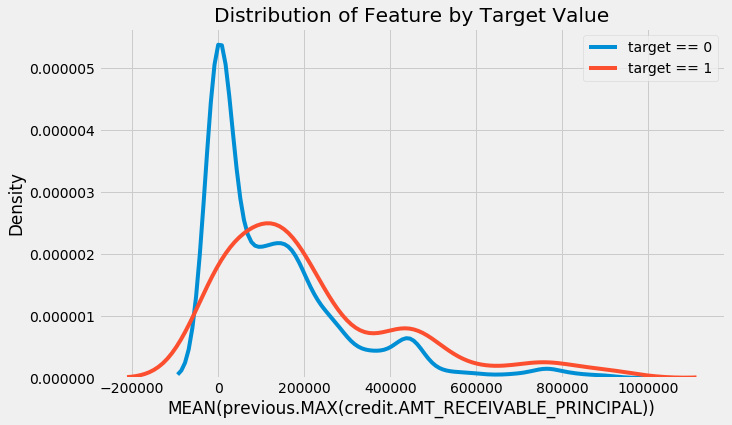

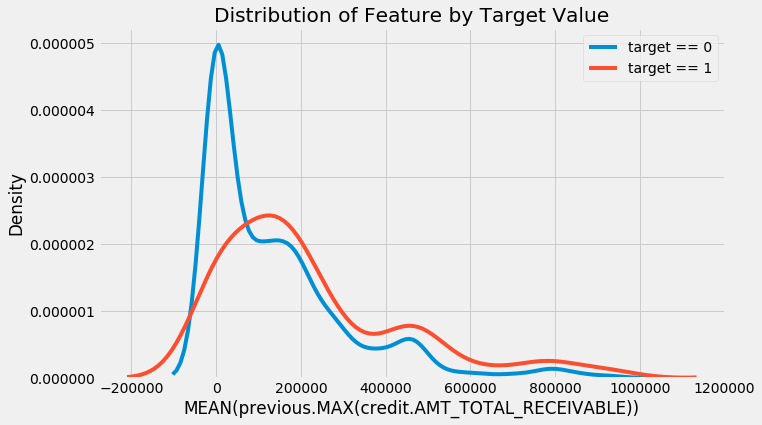

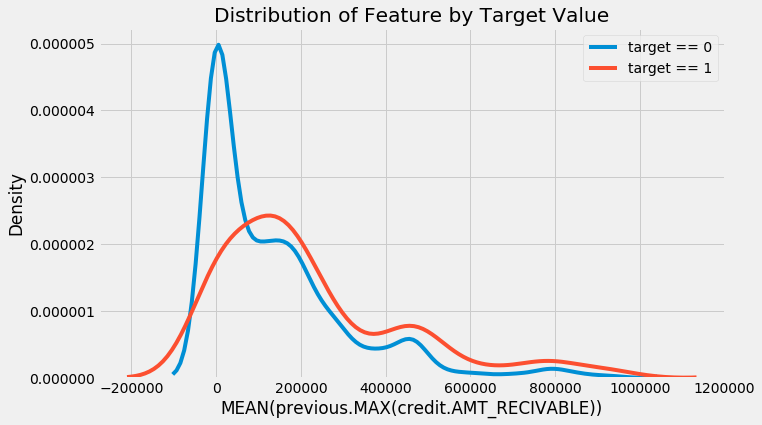

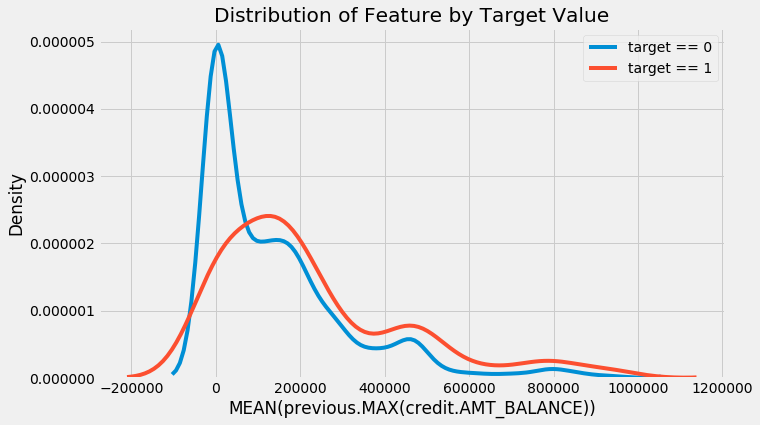

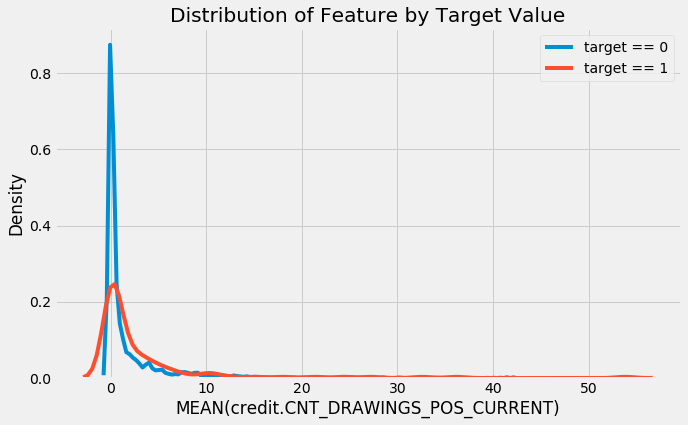

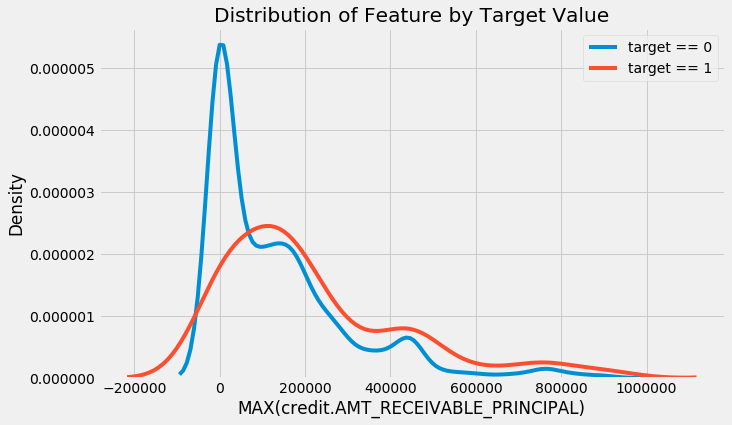

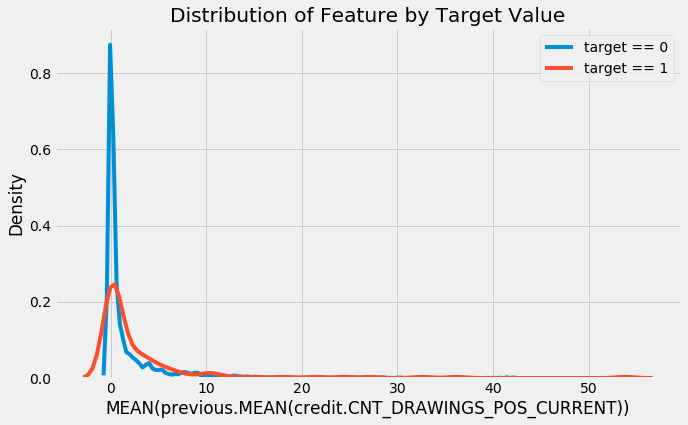

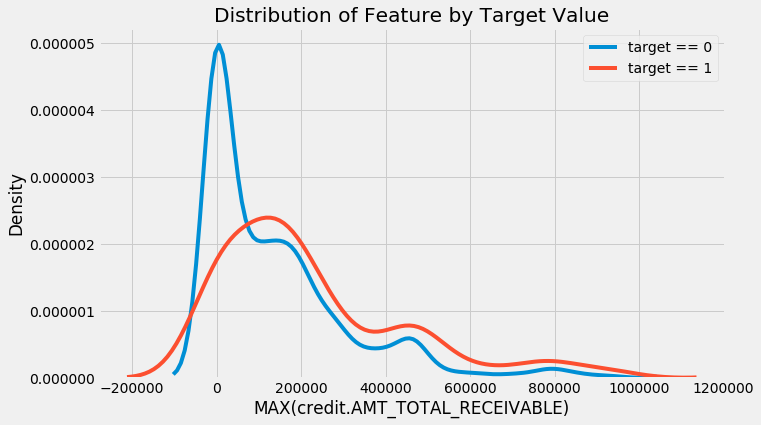

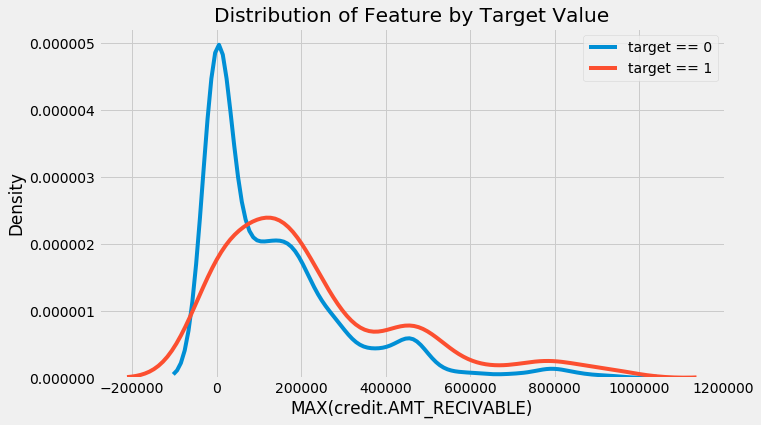

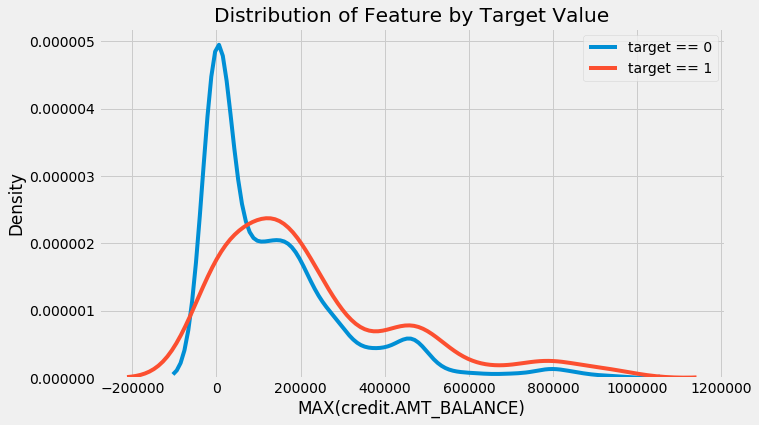

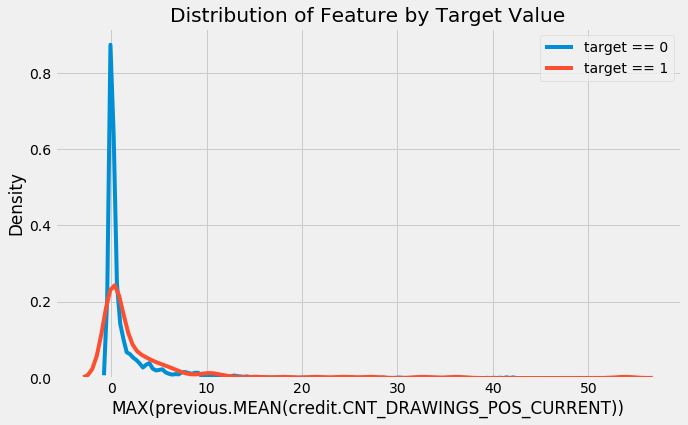

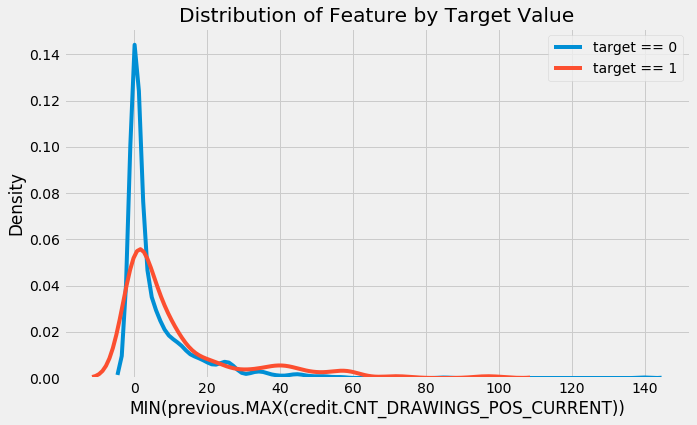

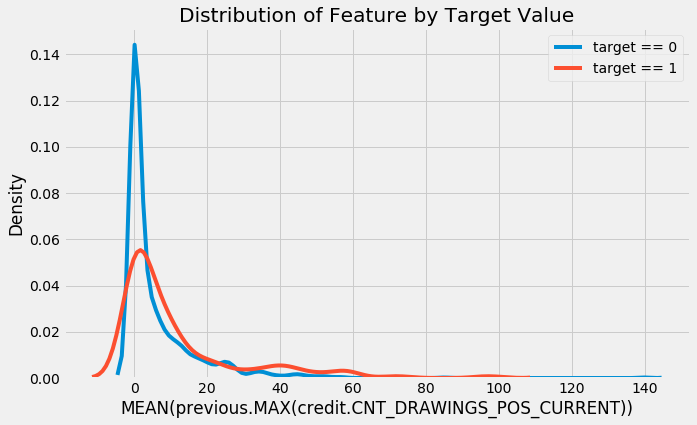

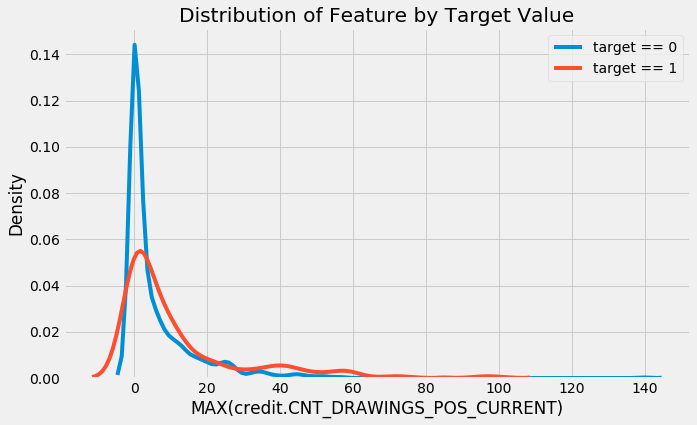

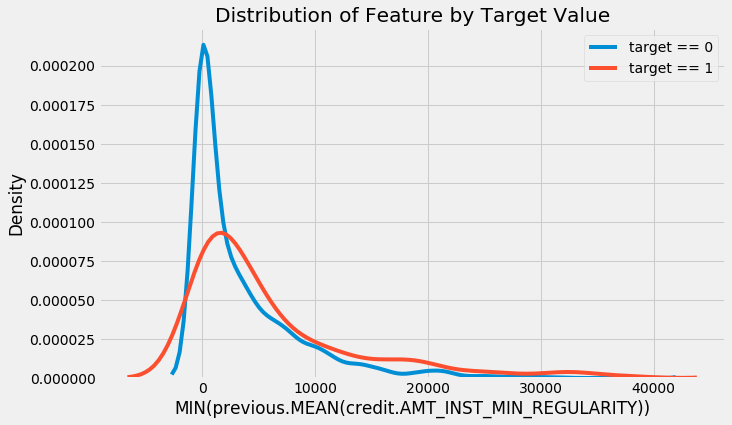

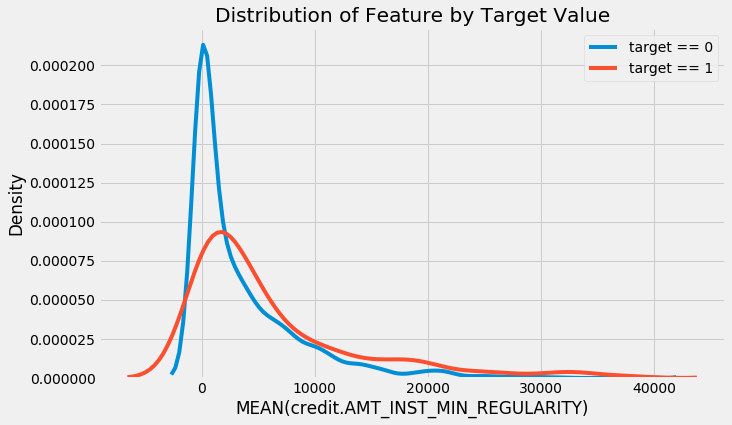

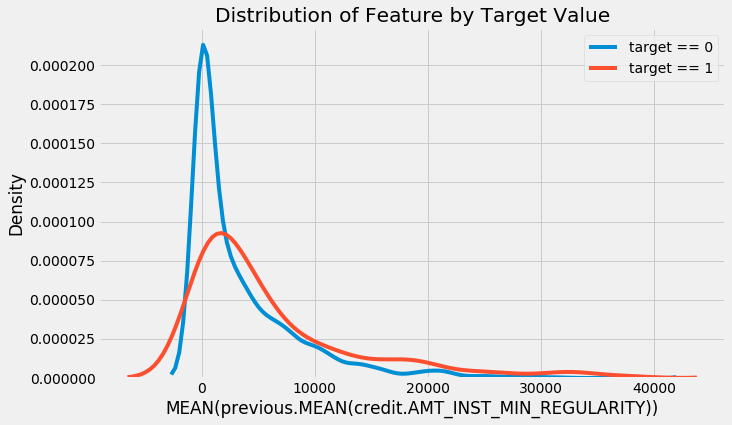

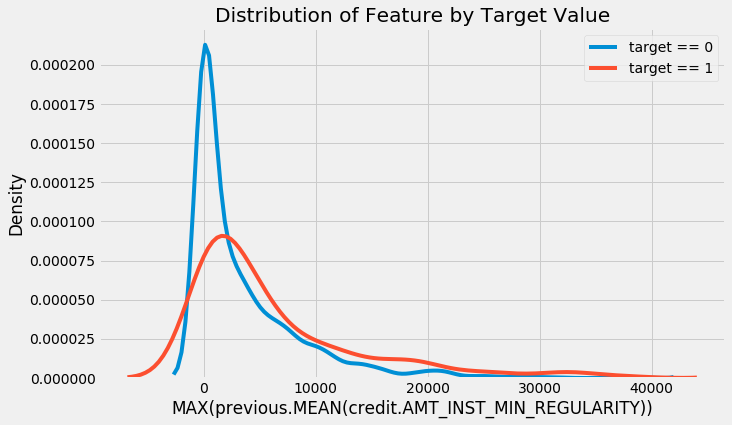

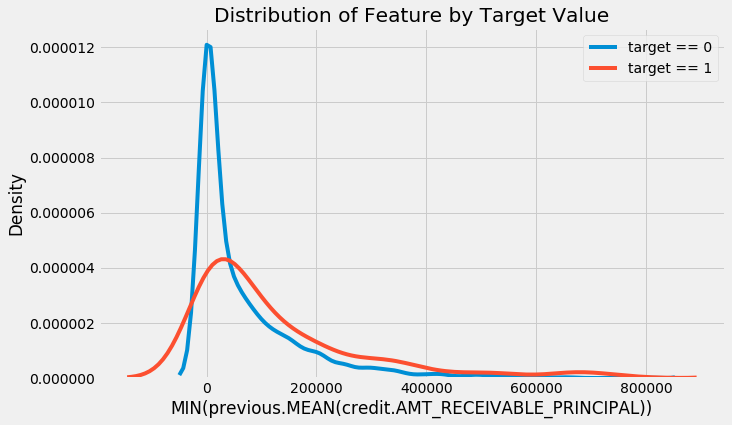

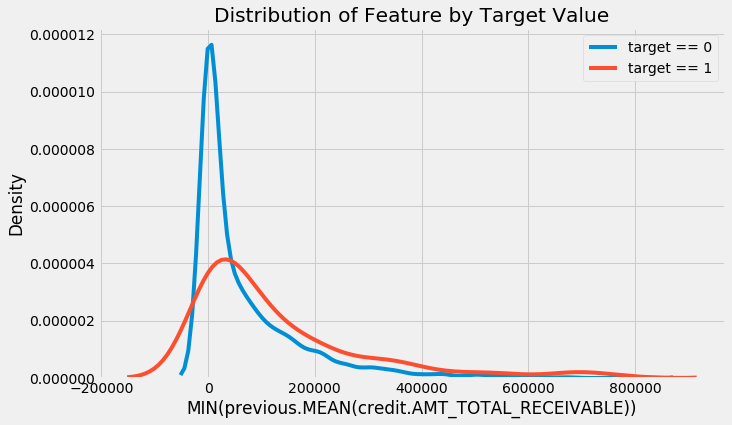

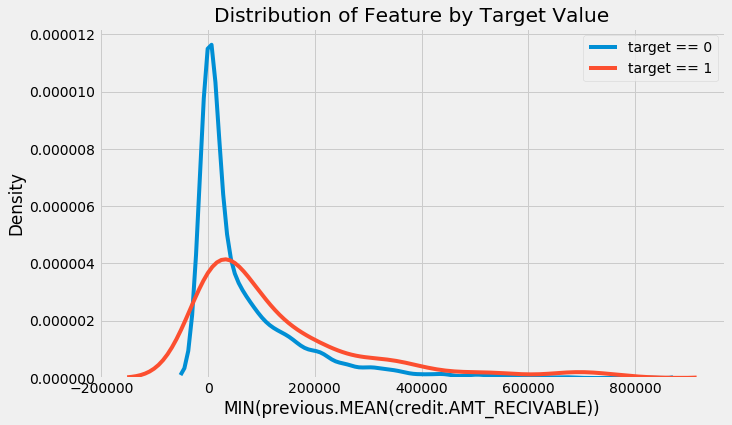

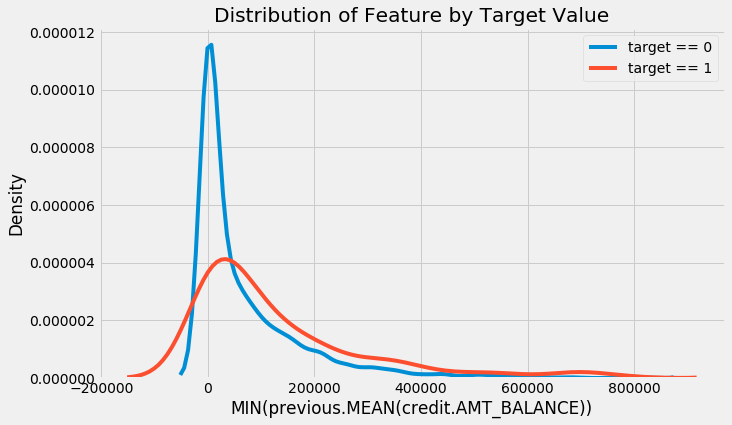

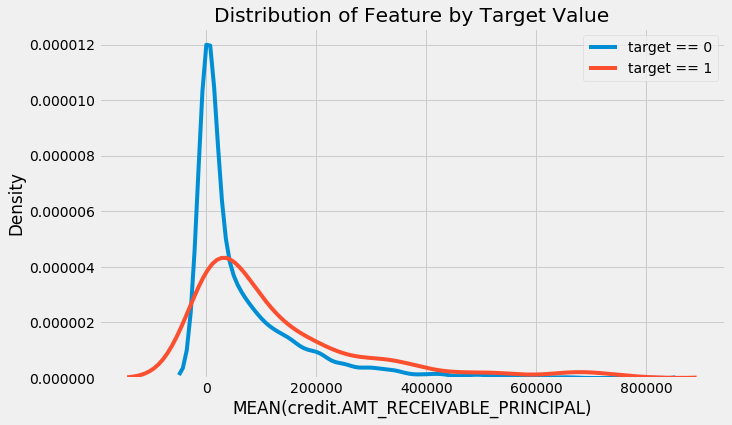

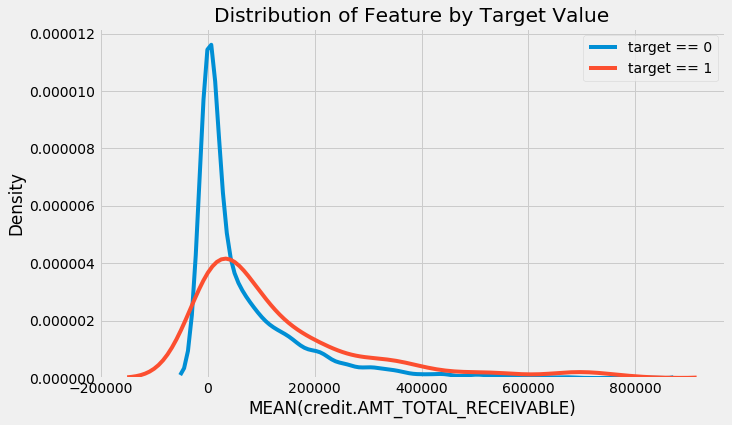

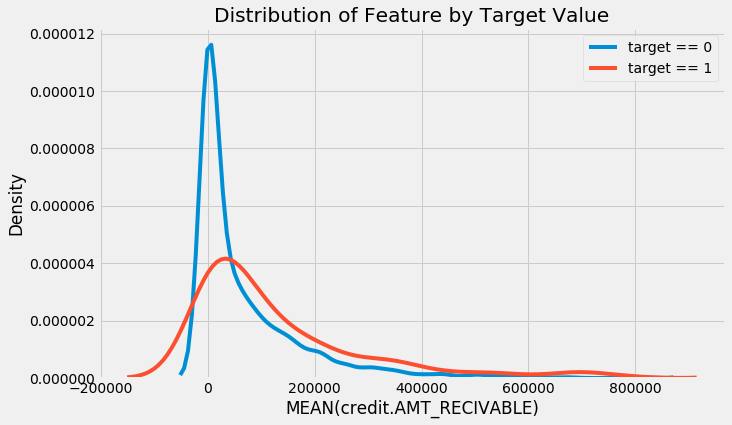

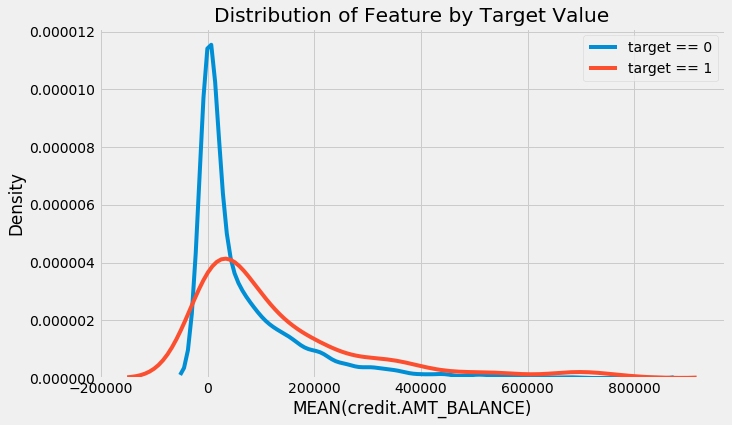

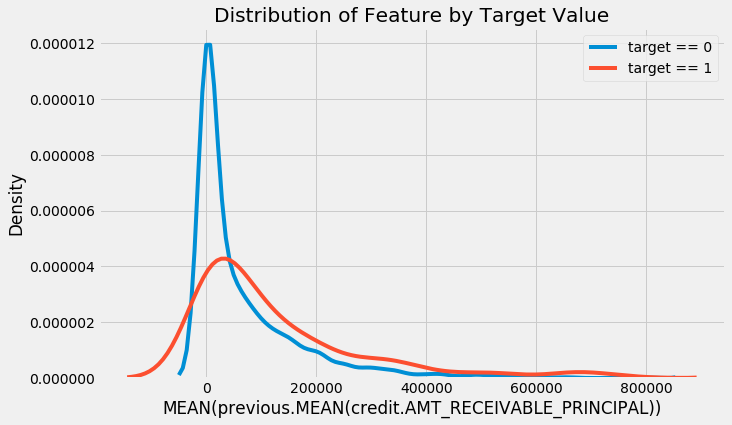

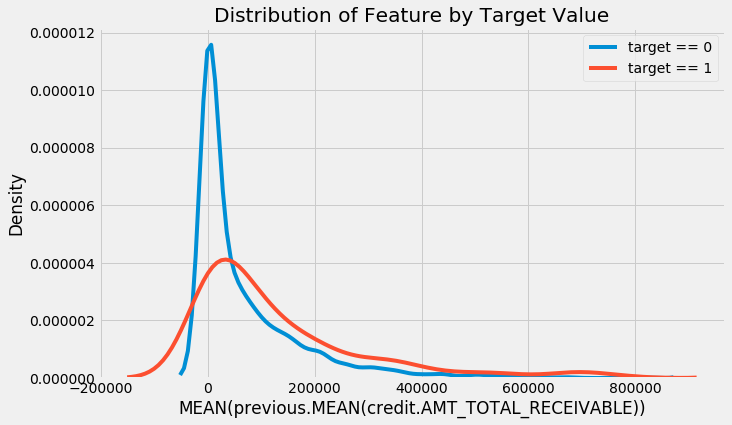

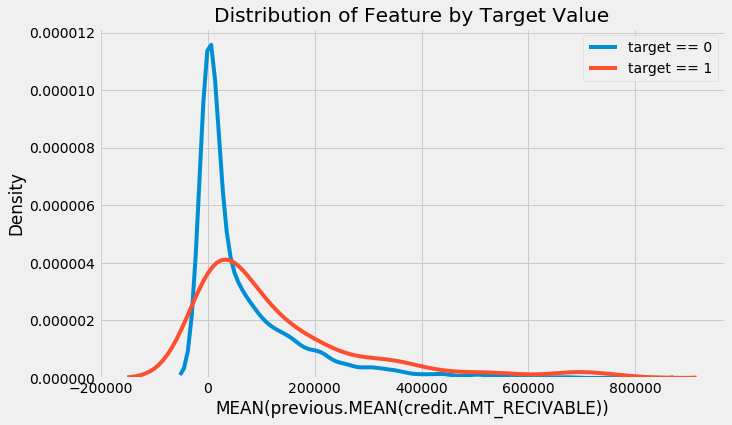

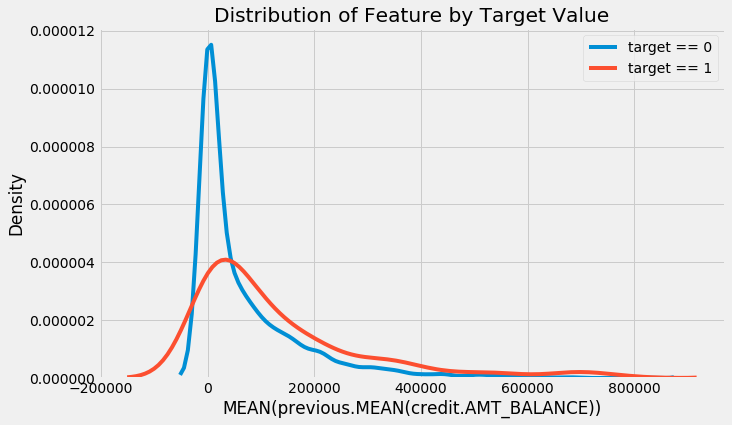

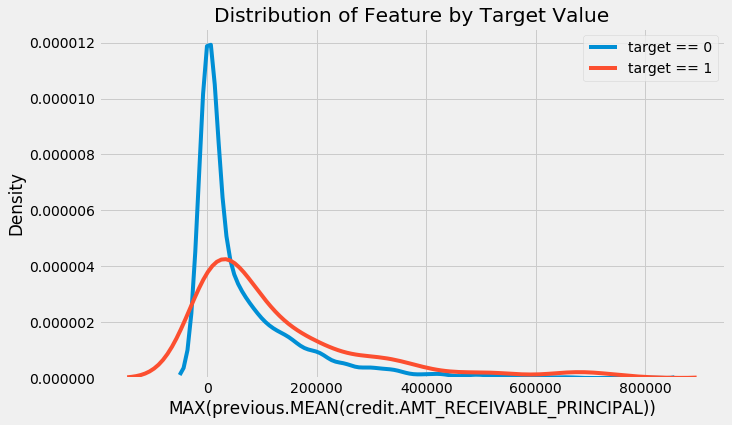

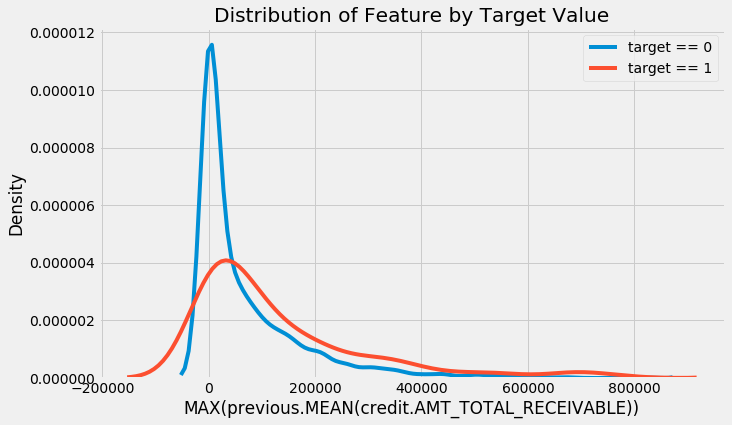

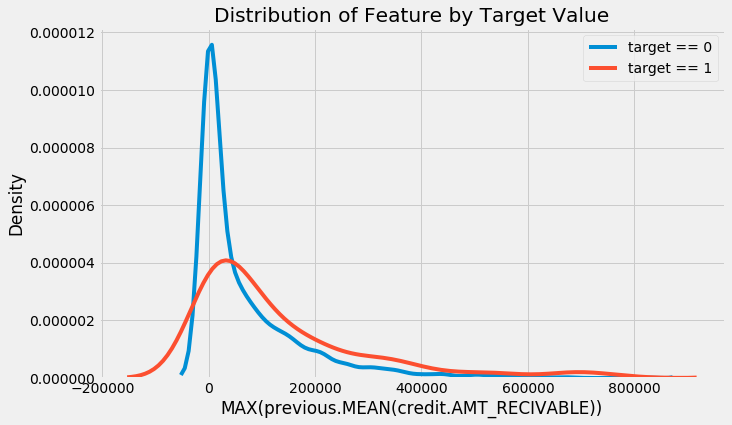

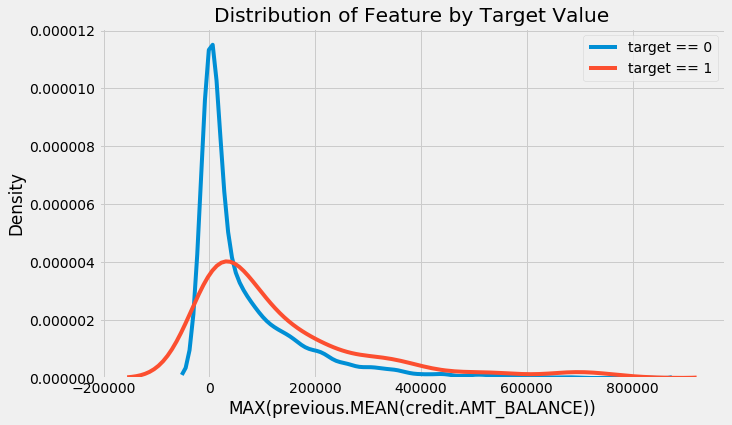

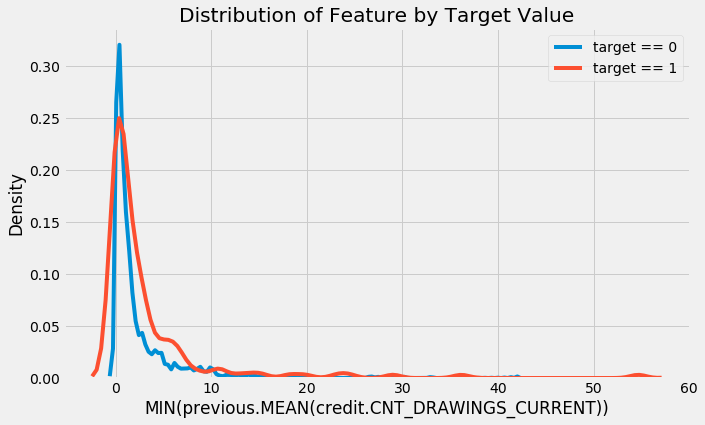

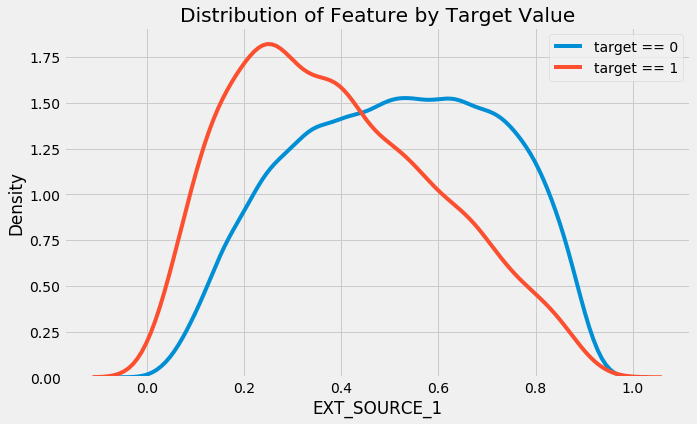

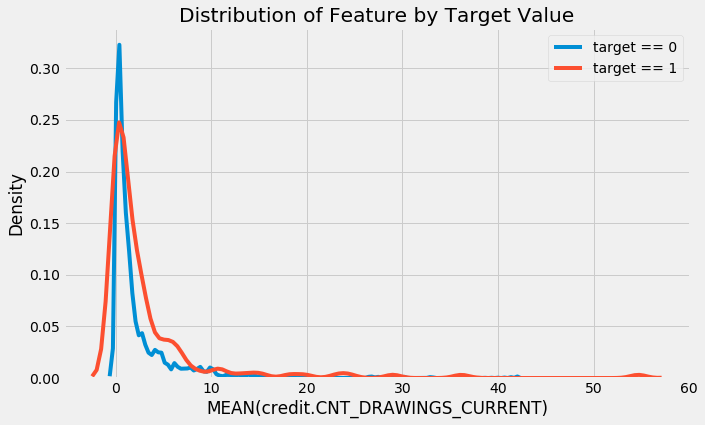

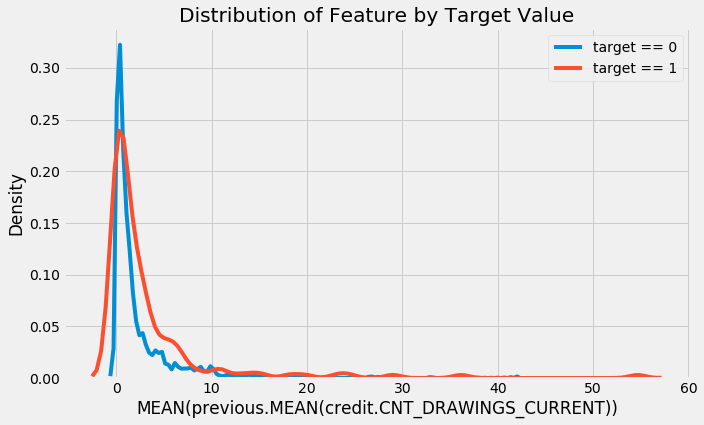

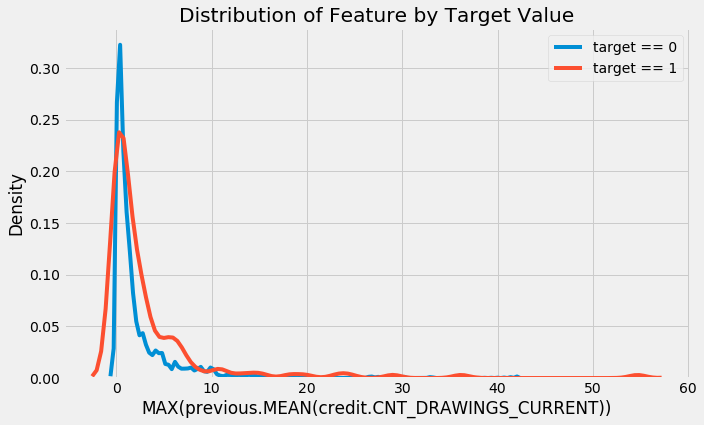

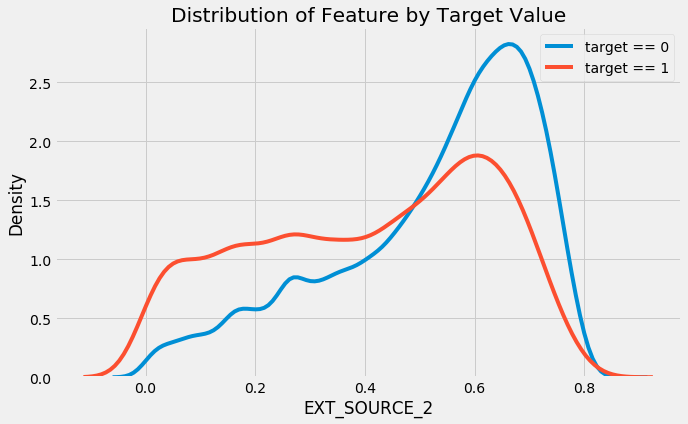

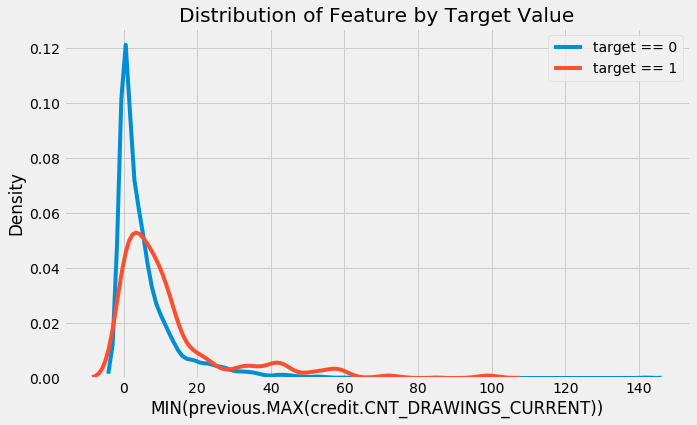

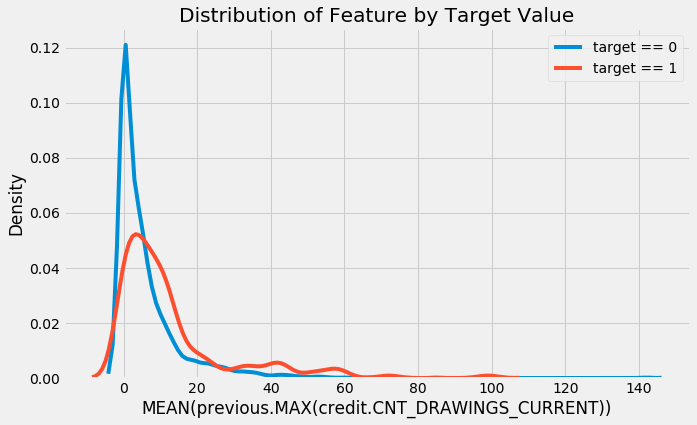

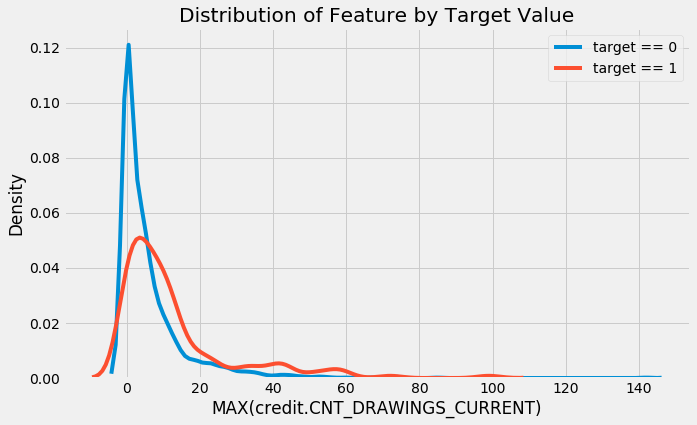

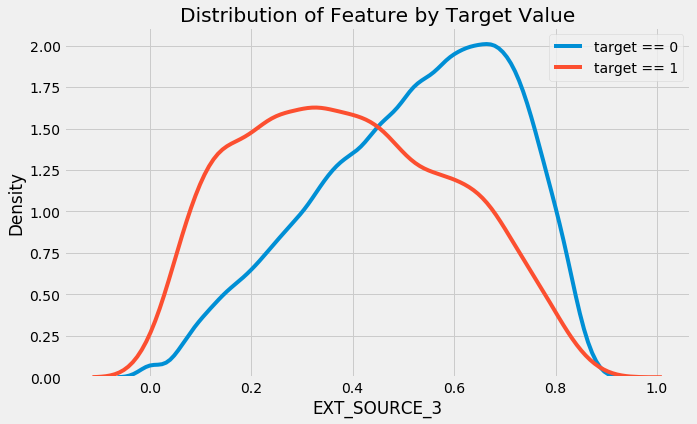

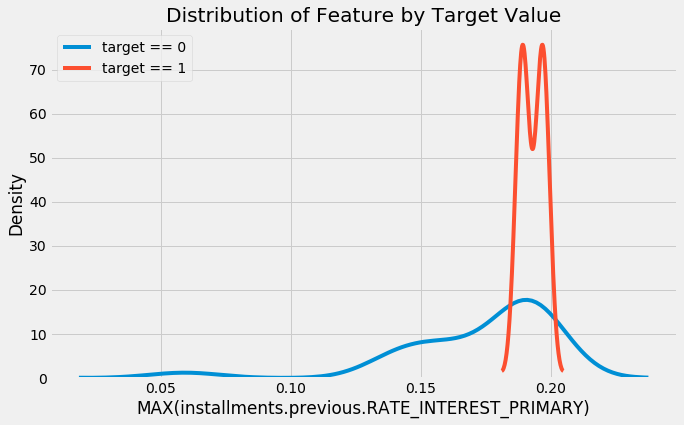

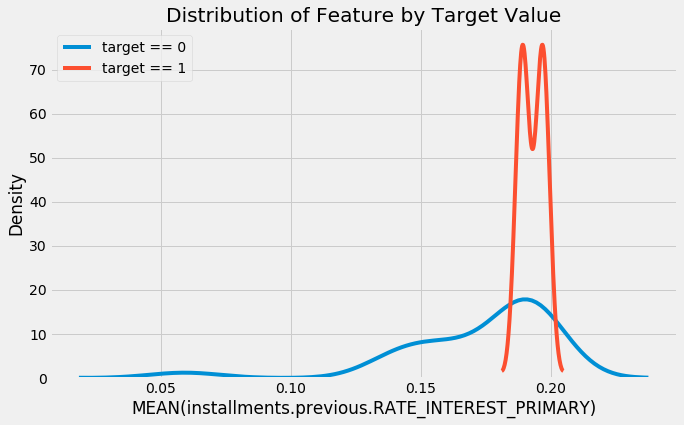

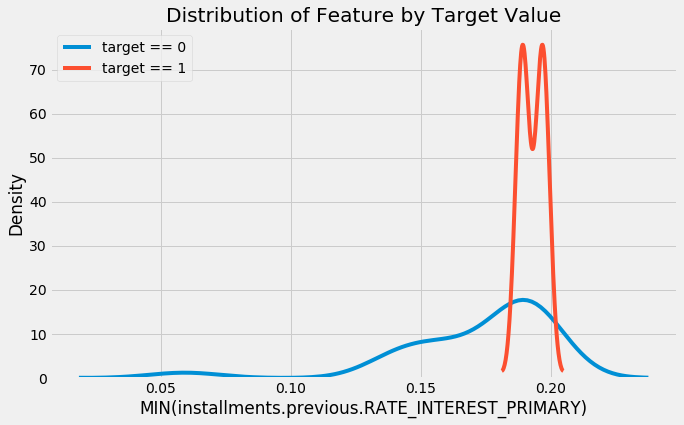

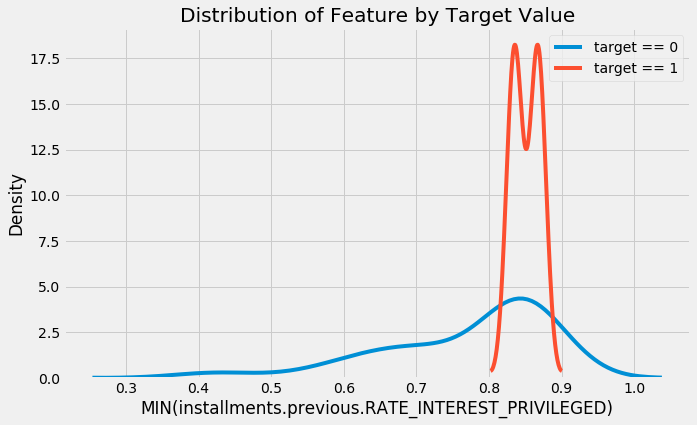

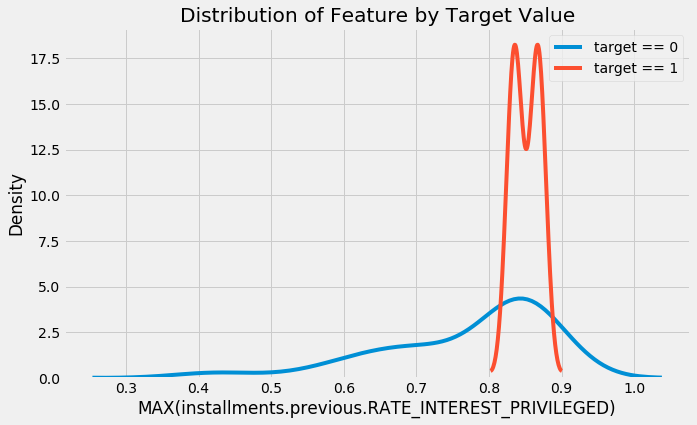

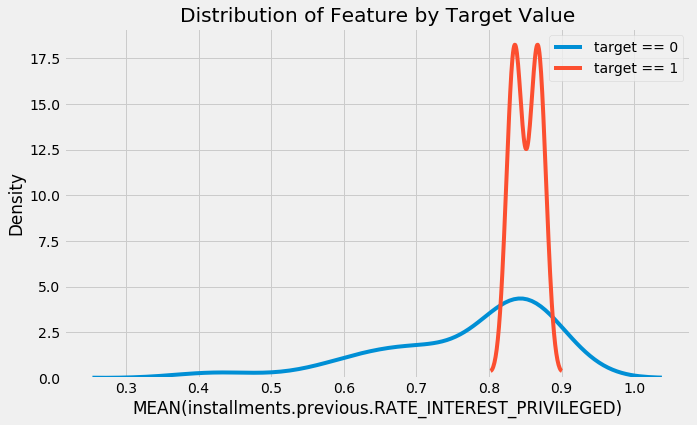

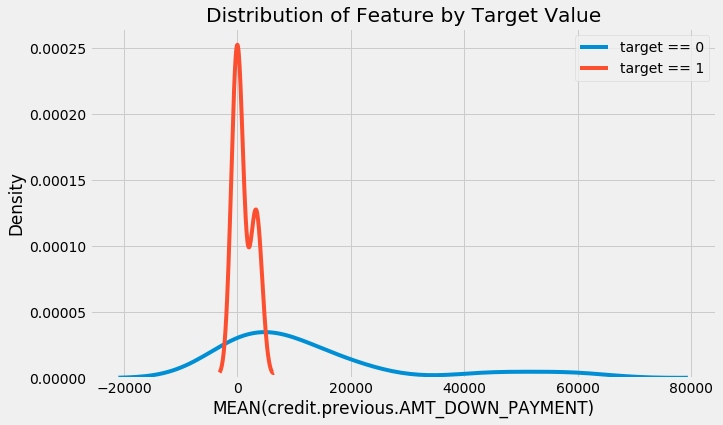

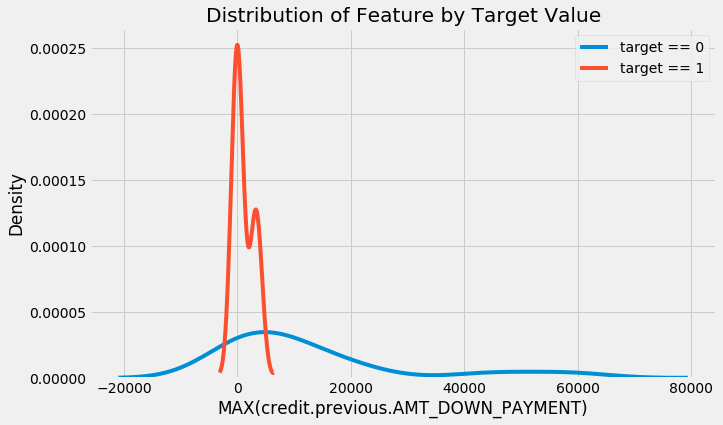

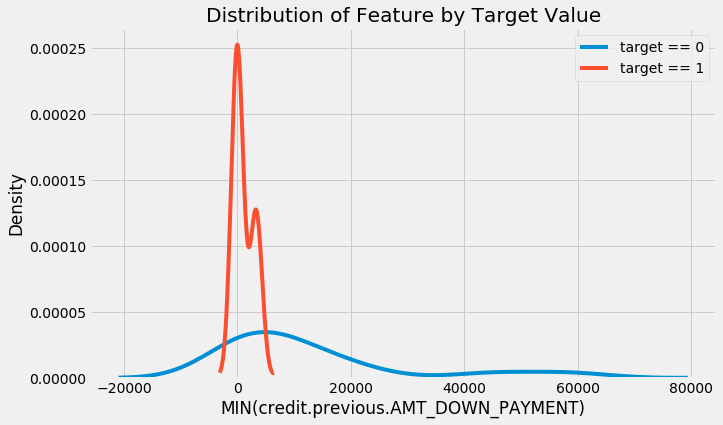

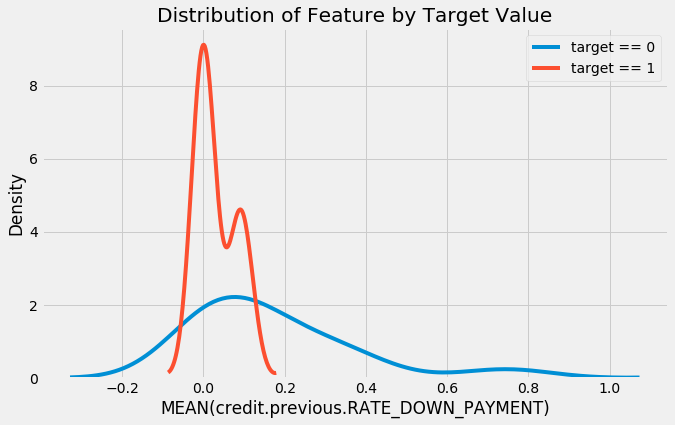

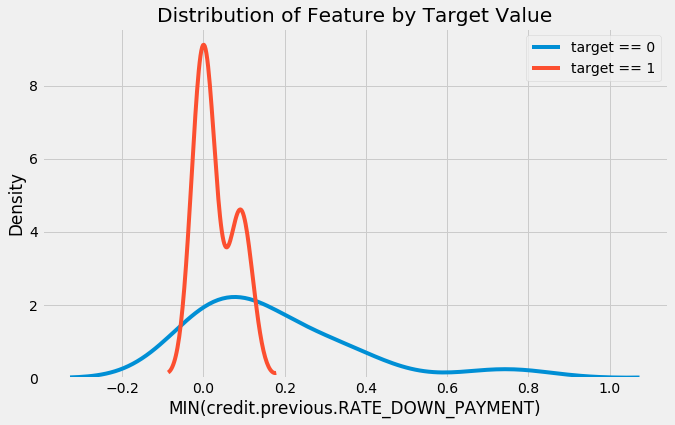

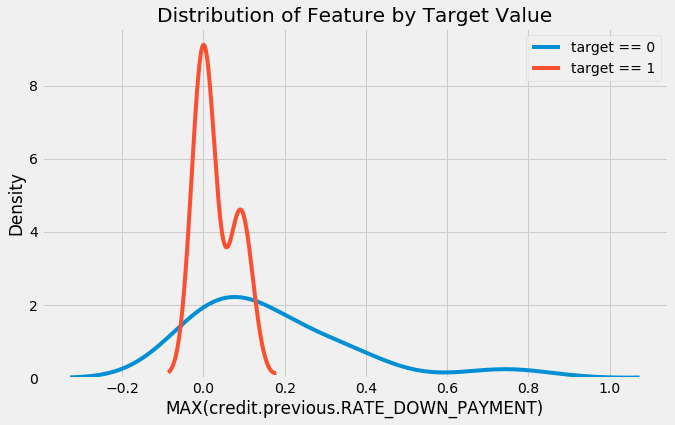

In [20]:
for a in corrssort.index:
    if corrssort[a] > 0.1 and corrssort[a] < 1:
        kde_target_plot(features_sample, feature = a)

**2-Collinear Features**

In [21]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in corrs:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(corrs.index[corrs[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [22]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MIN(bureau_balance.MONTHS_BALANCE)',
 'MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MIN(bureau.MEAN(bureau_balance.MONTHS_BALANCE))',
 'MIN(bureau_balance.bureau.DAYS_CREDIT)',
 'MIN(bureau_balance.bureau.DAYS_ENDDATE_FACT)',
 'MIN(bureau_balance.bureau.DAYS_CREDIT_UPDATE)',
 'MIN(bureau_balance.bureau.DAYS_CREDIT_ENDDATE)',
 'MIN(bureau_balance.bureau.AMT_CREDIT_SUM)',
 'MAX(bureau_balance.bureau.AMT_ANNUITY)',
 'MAX(bureau_balance.bureau.DAYS_CREDIT_UPDATE)',
 'MAX(bureau_balance.bureau.AMT_CREDIT_SUM_DEBT)',
 'MAX(bureau_balance.bureau.DAYS_CREDIT_ENDDATE)',
 'MAX(bureau_balance.bureau.AMT_CREDIT_SUM)',
 'MEAN(bureau_balance.bureau.AMT_ANNUITY)',
 'MEAN(bureau_balance.bureau.DAYS_ENDDATE_FACT)',
 'MEAN(bureau_balance.bureau.DAYS_CREDIT_UPDATE)',
 'MEAN(bureau_balance.bureau.AMT_CREDIT_SUM_DEBT)',
 'MEAN(bureau_balance.bureau.DAYS_CREDIT_ENDDATE)',
 'MEAN(bureau_balance.bureau.AMT_CREDIT_SUM)',
 'SUM(previous.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'SUM(previous.MEAN(credit.AMT_PAYMENT_TOTAL_

In [23]:
corrs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head()

MAX(bureau_balance.bureau.DAYS_CREDIT_UPDATE)     1.0
MIN(bureau_balance.bureau.DAYS_ENDDATE_FACT)      1.0
MEAN(bureau_balance.bureau.DAYS_CREDIT_UPDATE)    1.0
MEAN(bureau_balance.bureau.DAYS_ENDDATE_FACT)     1.0
MEAN(bureau_balance.bureau.AMT_ANNUITY)           1.0
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

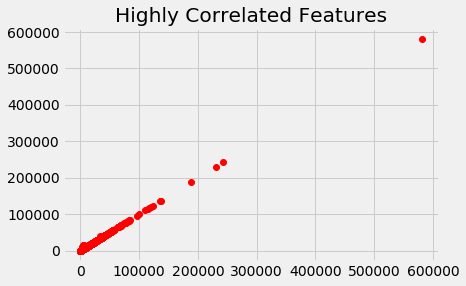

In [24]:
plt.plot(features_sample['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'], features_sample['MAX(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))'], 'ro')
plt.title('Highly Correlated Features');

**Modeling**

In [29]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation. 

    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, boosting_type = 'goss',
                   objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 

    return submission, feature_importances, metrics

In [26]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [27]:
# Separate out the train and test sets
train = feature_matrix[feature_matrix['set'] == 'train']
test = feature_matrix[feature_matrix['set'] == 'test']

# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Align dataframes on the columns
train, test = train.align(test, join = 'inner', axis = 1)
test = test.drop(columns = ['TARGET'])

print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (100001, 1629)
Final Testing Shape:  (48744, 1628)


In [30]:
submission, fi, metrics = model(train, test)

Training Data Shape:  (100001, 1627)
Testing Data Shape:  (48744, 1627)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.857015	train's binary_logloss: 0.493034	valid's auc: 0.759452	valid's binary_logloss: 0.528539
Early stopping, best iteration is:
[184]	train's auc: 0.851178	train's binary_logloss: 0.499377	valid's auc: 0.75979	valid's binary_logloss: 0.532619
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.862412	train's binary_logloss: 0.485347	valid's auc: 0.749919	valid's binary_logloss: 0.547963
Early stopping, best iteration is:
[153]	train's auc: 0.844807	train's binary_logloss: 0.50558	valid's auc: 0.750831	valid's binary_logloss: 0.558593
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.862116	train's binary_logloss: 0.485895	valid's auc: 0.753561	valid's binary_logloss: 0.546571
Early stopping, best iteration is:
[130]	train's auc: 0.834149	train's binary_logloss: 0.51748

In [31]:
metrics

fold     train     valid
0        0  0.851178  0.759790
1        1  0.844807  0.750831
2        2  0.834149  0.753747
3        3  0.879426  0.750094
4        4  0.879259  0.755583
5  overall  0.857764  0.753715

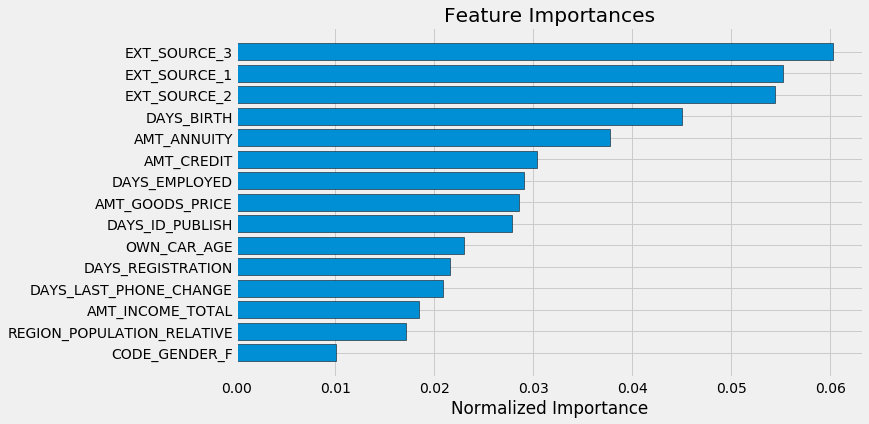

In [32]:
fi_sorted = plot_feature_importances(fi)

In [33]:
submission.to_csv('AutoEngineering.csv', index = False)